# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint



### Not for Grading

### Setup Steps

In [1]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2100121" #@param {type:"string"}


In [2]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "5142192291" #@param {type:"string"}


In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()
  
notebook= "U3W13_Demo_CNN_Pytorch" #name of the notebook
Answer = "Ungraded"
def setup():

    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "feedback_experiments_input" : Comments, "notebook" : notebook}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:        
        print(r["err"])
        return None   
      else:
        print("Your submission is successful.")
        print("Ref Id:",submission_id)
        print("Date of submission: ",r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://aiml.iiith.talentsprint.com/notebook_submissions")
        # print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if not Additional: 
      raise NameError
    else:
      return Additional  
  except NameError:
    print ("Please answer Additional Question")
    return None
def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError 
    else: 
      return Answer
  except NameError:
    print ("Please answer Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
    
else:
  print ("Please complete Id and Password cells before running setup")


Setup completed successfully


# Introduction

This notebook aims at discovering Convolutional Neural Network. We will see the theory behind it, and an implementation in Pytorch on FashionMNIST dataset.


In [4]:
# ! pip install --user -r requirements.txt
! pip install  torchviz 

     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=c646a8eec3a7910f61bdf7d16ae49ab3a07694857ef111e3d368902326e12dc3
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [5]:
!pip install matplotlib-venn

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import datasets, transforms, models

from torchviz import make_dot

import numpy as np

import os
os.environ["PATH"] += os.pathsep + r"libraries/graphviz-2.38/release/bin"

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes

![FashionMNIST Dataset](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

Pytorch's torchvision module conveniently packages the FashionMNIST dataset into a `torchvision.datasets.FashionMNIST` class for us. We simply need to specify the dataset split (train/test) and the **transformations** and **augmentations** we want to apply on each image. We wrap the dataset objects via Pytorch's **`torch.utils.data.DataLoader`** class to get dataloaders which will return entire batches of samples, and also optionally shuffle the dataset internally.

In [7]:
'''
Training time transformations and problem specific data augmentations can be applied here.
see : https://pytorch.org/docs/stable/torchvision/transforms.html
'''
transforms_train = transforms.Compose([
    transforms.ToTensor(),
    # We've computed the mean and variance for this dataset beforehand, 
    #so we can plug it in here
    transforms.Normalize((0.1307,), (0.3081,)) 
])
'''
FashionMNIST is a subclass of torch.utils.data.Dataset, and have __getitem__ and __len__ methods implemented. For creating
custom datasets you will have to inherit Dataset class and override __len__() and __getitem__()
'''
dataset_train = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transforms_train
)
'''
Pass dataset object to DataLoader, which will later be used for iterating over minibatches
'''
dataloader_train = DataLoader(
    dataset_train, batch_size=128, shuffle=True,
)

'''
Repeat the same thing (defining transforms => dataset instantiation => dataloader creationg) for the test set
'''
transforms_test =transforms.Compose([
    transforms.ToTensor(),
    # We've computed the mean and variance for this dataset beforehand, so we can plug it in here
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset_test = datasets.FashionMNIST(
    root='./data', train=False, download=False, transform=transforms_test
)

dataloader_test = DataLoader(
    dataset_test, batch_size=128, shuffle=False,
)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!






/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We now create a CNN class, which has to be a subclass of `torch.nn.Module` and have its own `__init__` and `forward` functions. 

We choose a simple architecture with `3 convolutional blocks` followed by `2 fully connected blocks`.

For layers that do not have any parameters, i.e. layers that are simple mathematical operations on the input, such as ReLU, sigmoid, tanh, softmax, dropout, etc., Pytorch provides a `torch.nn.functional` module with such layers.

While one can create a ReLU layer by using `nn.ReLU`, it's easier to just call `torch.nn.functional.relu` on a tensor. This helps reduce clutter, since large models can have many such layers.

NOTE: We import `torch.nn.functional` as the alias `F`.

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([128, 1, 28, 28]) torch.Size([128]) torch.Size([128, 10])


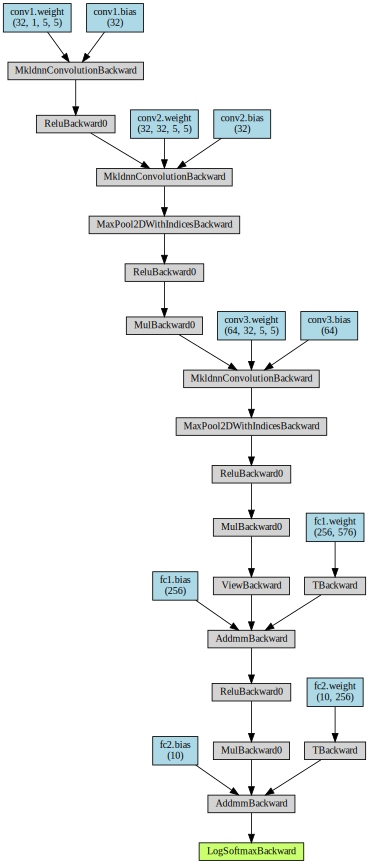

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # nn.Conv2d API : torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)  # 32 filters of 5x5 size and depth 1 (since input channel = 1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5) # 32 filters of 5x5 size and depth 32 (since input channel =  1)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5) # 64 filters of 5x5 size and depth 32 #params = 64x5x5x32 + 64
        # nn.Linear API : torch.nn.Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # BLOCK 1: CONV + RELU
        x = F.relu(self.conv1(x))
        # BLOCK 2: CONV + MAXPOOL + RELU + DROPOUT
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training) 
        # BLOCK 3: CONV + MAXPOOL + RELU + DROPOUT
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        
        # FLATTEN
        x = x.flatten(start_dim=1)
        # BLOCK 4: FC + RELU + DROPOUT
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # BLOCK 5: FC + LOG SOFTMAX
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

model = CNN()
print(model)

# get a random training batch
iterator = iter(dataloader_train)
X_batch, y_batch = next(iterator)
print(X_batch.shape, y_batch.shape, model(X_batch).shape)

# pass a batch through the model and visualize the architecture
# NOTE: we do not have to explicitly call model.forward(inputs), 
#instead we just do model(inputs)
# This is because PyTorch internally takes care of, giving us this syntactic sugar
make_dot(model(X_batch), params=dict(model.named_parameters()))

##Mymodel

In [3]:
class MyModel(nn.Module):
    def __init__(self):
        
        super().__init__()
        

        self._body= nn.Sequential( 

             #1: Conv2d, BN, ReLU, Pooling
             nn.Conv2d(1, 32, kernel_size=5, stride=1),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(2),
             
             #2: Conv2d, BN, ReLU, Pooling
             nn.Conv2d(32, 32, kernel_size=5),
             nn.MaxPool2d(2),
            
             
             #3: Conv2d, BN, ReLU, Pooling
             nn.Conv2d(32,64, kernel_size=5),
            
          
             )


        self._head= nn.Sequential(
            

            #FC1, ReLU
            nn.Linear(3*3*64, 256),
            
            #FC1, ReLU
            nn.Linear(256, 10),

    
            )
         
        
    def forward(self, x):
        
        #Conv
        x= self._body(x)
        batch = x.size()[0] 
        numel = x.numel()//batch ## this is basically [b * c * fh * fw]/ b
        x= x.view(batch, numel)

        #FC
        x= self._head(x)
            
        
        return x

#display MyModel

In [5]:
mymodel = MyModel()
print(mymodel)

MyModel(
  (_body): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (_head): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)


Now we create some utility functions to help with the training and evaluation process. Most of this is **boilerplate** code that can be reused with simple changes.

For training, we iterate over the **datalaoder** to get **batches**, and for each batch we do the following: 

- move each batch onto the **specified device**
- perform a **forward** pass through the model to get the **outputs**
- compute the **loss** based on the **outputs** and **targets**
- compute the **gradients** via **backpropagation**
- **update** the weights via the **optimizer**

Certain layers, e.g. **dropout**, **operate** differently in **training** versus inference modes. To account for the same, we do:

- **model.train()** to set all such layers to training **mode**
- **model.eval()** to set all such layers to inference **mode**

In [10]:
def train(model, device, data_loader, optimizer, criterion, epoch):
    model.train()
    loss_train = 0
    num_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        prediction = output.argmax(dim=1)
        num_correct += prediction.eq(target).sum().item()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tAccuracy: {:.0f}%'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss_train / (batch_idx + 1),
                100. * num_correct / (len(data) * (batch_idx + 1))))
    loss_train /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_train, accuracy
    

def test(model, device, data_loader, criterion):
    model.eval()
    loss_test = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss_test += loss.item()  # sum up batch loss
            prediction = output.argmax(dim=1)
            num_correct += prediction.eq(target).sum().item()
    loss_test /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_test, accuracy

Now we put it all together:

- Create the model
- Set up the loss function (cross entropy)
- Add an optimizer (in this case, Adam)
- [Optional] Have a learning rate scheduler

In [11]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) #, betas=(0.9,0.999))

for epoch in range(1, 5):
    loss_train, acc_train = train(model, device, dataloader_train, optimizer, criterion, epoch)
    print('Epoch {} Train: Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_train, 100. * acc_train))
    loss_test, acc_test = test(model, device, dataloader_test, criterion)
    print('Epoch {} Test : Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_test, 100. * acc_test))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.3074	Accuracy: 12%
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.3943	Accuracy: 49%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.0934	Accuracy: 59%
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.9609	Accuracy: 64%
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.8824	Accuracy: 67%
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.8268	Accuracy: 69%
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.7859	Accuracy: 71%
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.7531	Accuracy: 72%
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.7275	Accuracy: 73%
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.7048	Accuracy: 74%
Epoch 1 Train: Loss: 0.6978, Accuracy: 74.228%

Epoch 1 Test : Loss: 0.4381, Accuracy: 83.800%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.5397	Accuracy: 82%
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.4794	Accuracy: 82%
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.4834	Accuracy: 82%
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.4814	Accuracy: 82%
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.4811	

## Please answer the questions below to complete the experiment:

In [ ]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good, But Not Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [ ]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "non" #@param {type:"string"}


In [ ]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]

In [ ]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Run this cell to submit your notebook  { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 10420
Date of submission:  02 Dec 2020
Time of submission:  02:30:42
View your submissions: https://aiml.iiith.talentsprint.com/notebook_submissions
